# Random Input

In [3]:
import pandas as pd

from utils import *
from spin_ham import *
from bounds import *
from trotter import *

from functools import partial
from qiskit.quantum_info import random_statevector

figs_dir, data_dir = './figs', './data'

## Power-law interaction

In [3]:
pow_test = Power_law(5, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=0.0, hy=0.0, hz=-0.5, pbc=False, verbose=False)
pow_test.ham
pow_test.ham_xyz
# commutator(pow_test.ham_xyz[0], pow_test.ham_xyz[1]).simplify()

[SparsePauliOp(['IIIXX', 'IIXIX', 'IXIIX', 'XIIIX', 'IIXXI', 'IXIXI', 'XIIXI', 'IXXII', 'XIXII', 'XXIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIYY', 'IIYIY', 'IYIIY', 'YIIIY', 'IIYYI', 'IYIYI', 'YIIYI', 'IYYII', 'YIYII', 'YYIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j,
  -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j])]

In [14]:
pow_law.ham_xyz[0]

SparsePauliOp(['IIXX', 'IXIX', 'XIIX', 'IXXI', 'XIXI', 'XXII'],
              coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j,
 -1.      +0.j])

------ n = 4 ------
----empirical observable error----
++++++++++------ n = 5 ------
----empirical observable error----
++++++++++------ n = 6 ------
----empirical observable error----
++++++++++------ n = 7 ------
----empirical observable error----
++++++++++------ n = 8 ------
----empirical observable error----
++++++++++------ n = 9 ------
----empirical observable error----
++++++++++------ n = 10 ------
----empirical observable error----
++++++++++------ n = 11 ------
----empirical observable error----
++++++++++

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


a_em: 5.307956203641871; b_em: -17.753969777528948
a_em: 4.787308225420465; b_em: -17.74245751039223
a_em: 4.70730447246531; b_em: -19.541833666033813
a_em: 4.22510505550175; b_em: -16.86367386023498
a_em: 0.8963609571568139; b_em: -16.1157280515741


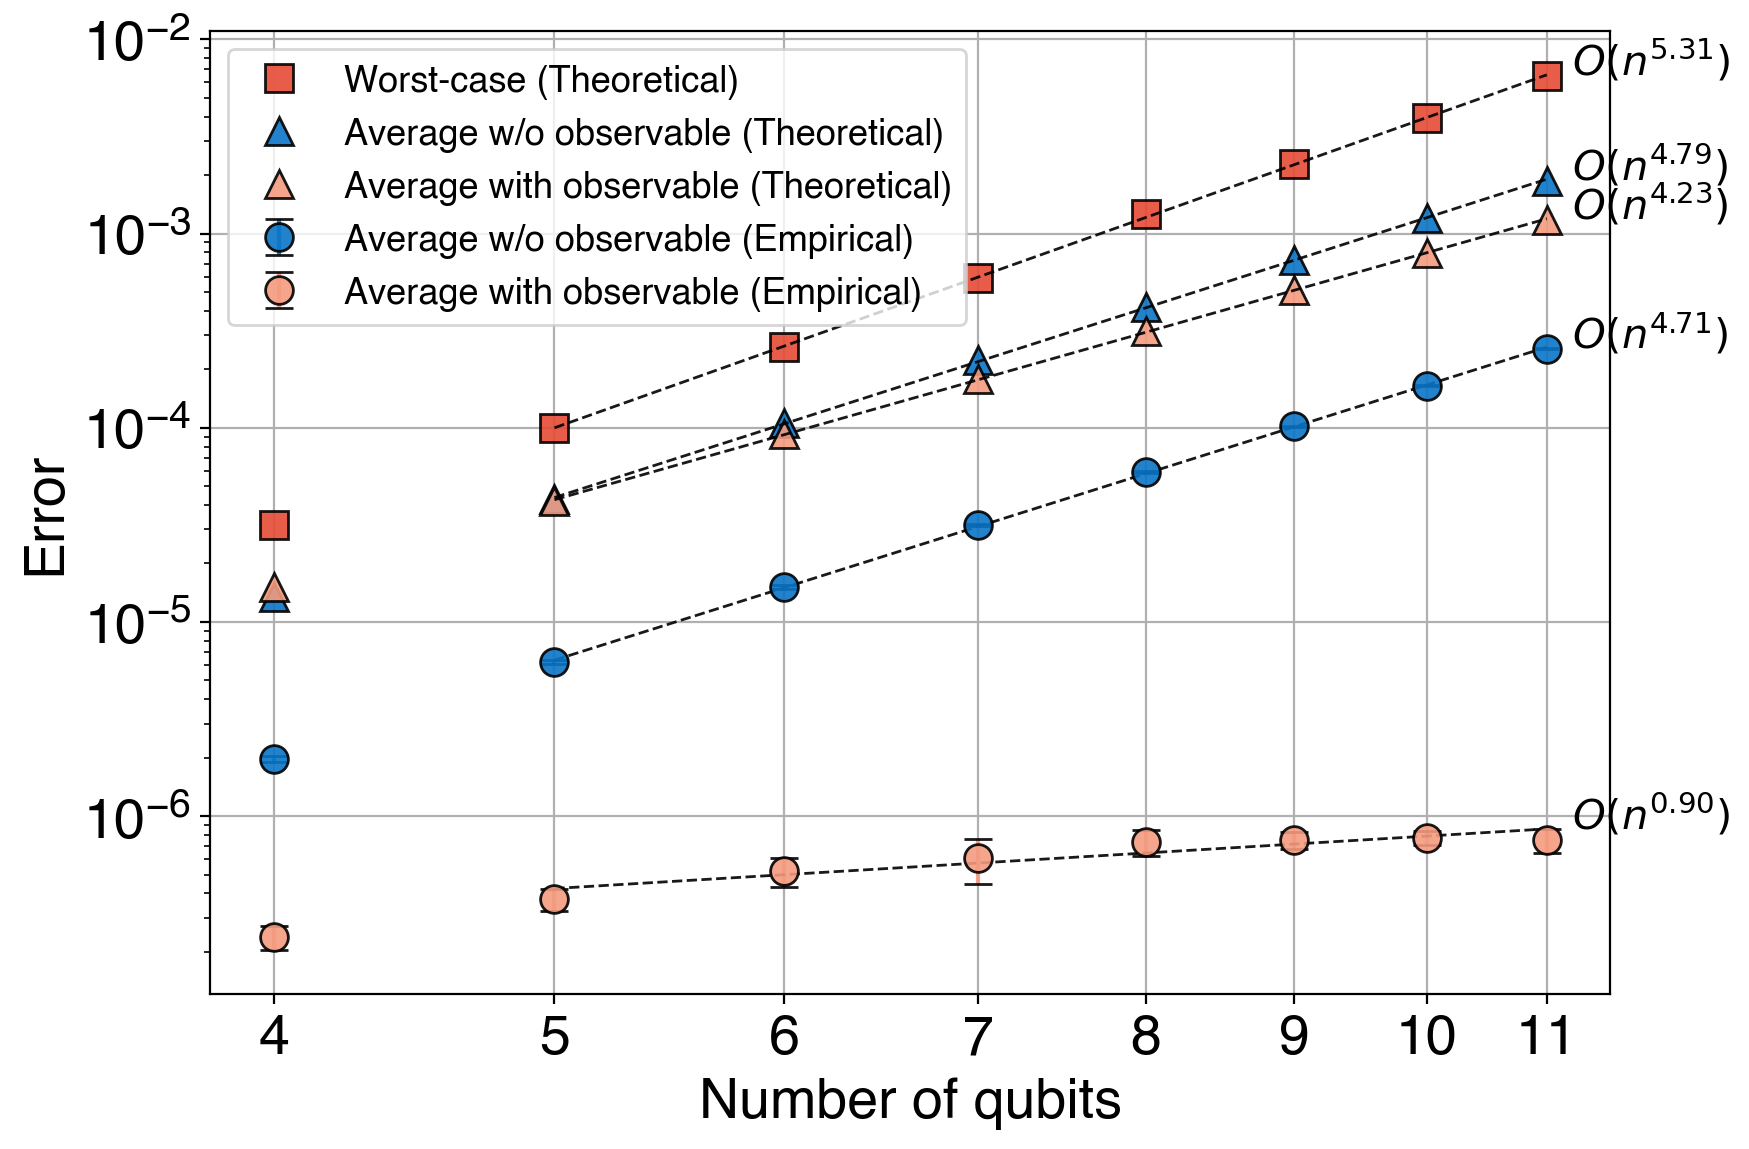

In [15]:
prefix, suffix = 'Pow', 'n'
n_max = 11
r = 10000 # 5000
eps = 1e-3
n_sample, n_round = 20, 10
n_list = np.arange(4, n_max+1)

data_keys = ['emp_worst', 'emp_averg', 'emp_averg_std', 'emp_averg_magn', 'emp_averg_corr', 'emp_averg_magn_std', 'emp_averg_corr_std', 'bnd_worst', 'bnd_averg', 'bnd_averg_magn', 'bnd_averg_corr', 'n']
data = dict([(k, []) for k in data_keys])
data['n'] = n_list

for n in n_list:
    print(f'------ n = {n} ------')
    pow_law = Power_law(n, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=-0.5, hy=0.0, hz=-0.0, pbc=False, verbose=False)
    # print('xyz group: ', pow_law.ham_xyz)
    # norm4 = nested_commutator_4norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
    # print('eeee:', norm4)
    # norm4_list.append(norm4)
    t = n
    corr_op = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n).to_matrix()
    # xyz_group = [h.to_matrix() for h in pow_law.ham_xyz]
    xyz_group = [h.to_matrix(True) for h in pow_law.ham_xyz]
    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in pow_law.ham_xyz]))

    data['emp_worst'].append(n * measure_error(r, xyz_group, t, exact_U, 'worst_empirical'))
    data['bnd_worst'].append(n * measure_error(r, xyz_group, t, exact_U, 'worst_bound'))
    data['bnd_averg'].append(n * measure_error(r, xyz_group, t, exact_U, 'average_bound'))
    data['bnd_averg_magn'].append(measure_error(r, xyz_group, t, exact_U, 'average_ob_bound', ob=magn_op))
    data['bnd_averg_corr'].append(measure_error(r, xyz_group, t, exact_U, 'average_ob_bound', ob=corr_op))

    magn_list, corr_list, stat_list = [], [], []
    print('----empirical observable error----')
    for _ in range(n_round):
        print('+', end='')
        rand_states = [random_statevector(2**n) for _ in range(n_sample)]

        stat_list.append(n * measure_error(r, xyz_group, t, exact_U, 'average_empirical', rand_states=rand_states))
        magn_list.append(measure_error(r, xyz_group, t, exact_U, 'average_ob_empirical', rand_states=rand_states, ob=magn_op))
        corr_list.append(measure_error(r, xyz_group, t, exact_U, 'average_ob_empirical', rand_states=rand_states, ob=corr_op))

    data['emp_averg'].append(np.mean(stat_list))
    data['emp_averg_magn'].append(np.mean(magn_list))
    data['emp_averg_corr'].append(np.mean(corr_list))
    data['emp_averg_std'].append(np.std(stat_list))
    data['emp_averg_magn_std'].append(np.std(magn_list))
    data['emp_averg_corr_std'].append(np.std(corr_list))
# save to csv
# print(pd.DataFrame(data))
pd.DataFrame(data).to_csv(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv', index=False)

# # plot results
fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
# ax.plot(n_list, norm4_list, 's', label='Norm4')
ax.plot(n_list, data['bnd_worst'], 's', label='Worst-case (Theoretical)')
ax.plot(n_list, data['bnd_averg'], '^', label='Average w/o observable (Theoretical)', color="#0A75C7")
ax.plot(n_list, data['bnd_averg_magn'], '^', label='Average with observable (Theoretical)', color="#F39B7FFF")
ax.errorbar(n_list, data['emp_averg'], data['emp_averg_std'], fmt='o', label='Average w/o observable (Empirical)', capsize=5, color="#0A75C7")
ax.errorbar(n_list, data['emp_averg_magn'], data['emp_averg_magn_std'], fmt='o', label='Average with observable (Empirical)', capsize=5, color="#F39B7FFF")

plot_fit(ax, n_list[1:], data['bnd_worst'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg_magn'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg_magn'][1:], var=suffix, x_offset=1.02)
ax.set_xlabel(rf'Number of qubits')
ax.set_ylabel(rf'Error')
ax.loglog(); ax.grid()
ax.set_xticks(n_list)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.legend()
plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
# ax.legend(loc='center right', bbox_to_anchor=(1.0, 0.32))
fig.savefig(f'{figs_dir}/random_{prefix}_max={n_list[-1]}_{suffix}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


a_em: 5.307956203641871; b_em: -17.753969777528948
a_em: 4.787308225420465; b_em: -17.74245751039223
a_em: 4.70730447246531; b_em: -19.541833666033813
a_em: 4.22510505550175; b_em: -16.86367386023498
a_em: 0.8963609571568139; b_em: -16.1157280515741


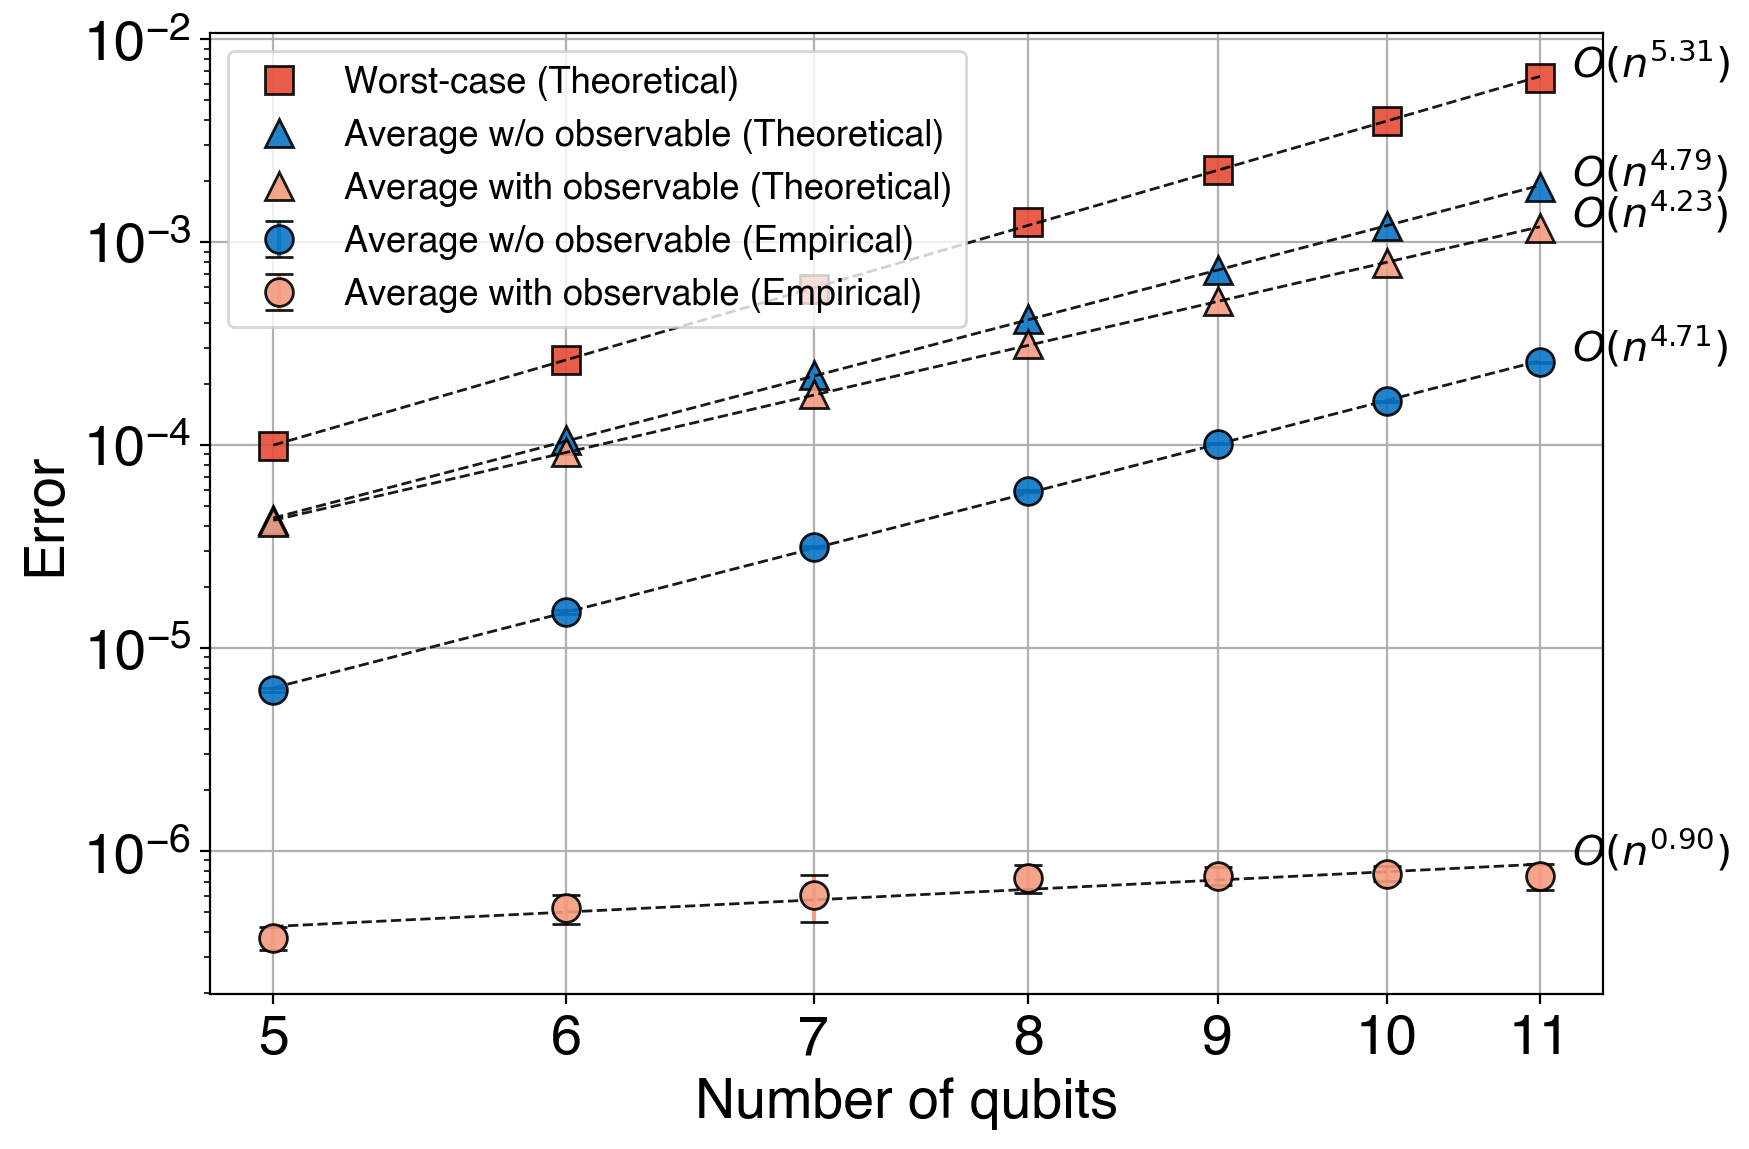

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
# ax.plot(n_list, norm4_list, 's', label='Norm4')
ax.plot(n_list[1:], data['bnd_worst'][1:], 's', label='Worst-case (Theoretical)')
ax.plot(n_list[1:], data['bnd_averg'][1:], '^', label='Average w/o observable (Theoretical)', color="#0A75C7")
ax.plot(n_list[1:], data['bnd_averg_magn'][1:], '^', label='Average with observable (Theoretical)', color="#F39B7FFF")
ax.errorbar(n_list[1:], data['emp_averg'][1:], data['emp_averg_std'][1:], fmt='o', label='Average w/o observable (Empirical)', capsize=5, color="#0A75C7")
ax.errorbar(n_list[1:], data['emp_averg_magn'][1:], data['emp_averg_magn_std'][1:], fmt='o', label='Average with observable (Empirical)', capsize=5, color="#F39B7FFF")

plot_fit(ax, n_list[1:], data['bnd_worst'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg_magn'][1:], var=suffix, x_offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg_magn'][1:], var=suffix, x_offset=1.02)
ax.set_xlabel(rf'Number of qubits')
ax.set_ylabel(rf'Error')
ax.loglog(); ax.grid()
ax.set_xticks(n_list[1:])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.legend()
plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
fig.savefig(f'{figs_dir}/random_{prefix}_max={n_list[-1]}_{suffix}_sample={n_sample}_n=5.pdf', dpi=150, bbox_inches='tight')

## Nearest-neighbor interaction

### Transver-field Ising (TFI)

In [18]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
# n = 8; 
# t = 0.5
r = 200
n_list_emp = range(4, 10)
rand_err_list, EEEE_err_list, E_norm_list = [], [], []

for n in n_list_emp:
    tfI = TF_Ising_1d(n, J, h)
    t = n
    exact_U = expm(-1j * t/r * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t/r, 1)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    err_op = exact_U - appro_U_parity
    rand_err = 2 * r * (np.trace(err_op @ err_op.conj().T @ err_op @ err_op.conj().T)/2**n)**(1/4) * (np.trace(magn_op @ magn_op @ magn_op @ magn_op)/2**n)**(1/4)
    EEEE_err = (np.trace(err_op @ err_op.conj().T @ err_op @ err_op.conj().T)/2**n)**(1/4) 
    rand_err_list.append(rand_err)
    EEEE_err_list.append(EEEE_err)
    E_norm_list.append(np.linalg.norm(err_op, ord=2))


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hlines(1e-3, 4, 9, 'k', '--')

ax.plot(n_list_emp, rand_err_list, 'o', label='random error bound')
plot_fit(ax, n_list_emp, rand_err_list)

ax.plot(n_list_emp, EEEE_err_list, 'o', label='(tr(EEEE)/2^n)^1/4')
plot_fit(ax, n_list_emp, EEEE_err_list)

ax.plot(n_list_emp, E_norm_list, 'o', label='E norm')
plot_fit(ax, n_list_emp, E_norm_list)

ax.set_xlabel('n')
ax.set_ylabel('Random err bound')
ax.set_title(f'PF2, TFI (J={J}, h={h}), t=n, r={r}')
ax.loglog()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(n_list_emp)
ax.legend(); ax.grid()

NameError: name 'standard_trotter' is not defined

In [7]:
from qiskit.quantum_info import random_statevector

prefix, suffix = 'TFI', 'n'
n_max = 8
J, h = 1, 0.5
eps = 1e-3
n_sample, n_round = 20, 10
n_list = np.arange(4, n_max+1)

data_keys = ['emp_worst', 'emp_averg', 'emp_averg_std', 'emp_averg_magn', 'emp_averg_corr', 'emp_averg_magn_std', 'emp_averg_corr_std', 'bnd_worst', 'bnd_averg', 'bnd_averg_magn', 'bnd_averg_corr', 'n']
# data = dict([(k, {key: [] for key in ['emp', 'bnd']} ) for k in ob_keys])
data = dict([(k, []) for k in data_keys])
data['n'] = n_list

In [8]:
# emp_worst_list, emp_averg_list, emp_obser_list, emp_corre_list = [], [], [], []
# bnd_worst_list, bnd_averg_list, bnd_averg_magn_list = [], [], []

for n in n_list:
    print(f'------ n = {n} ------')
    tfi = TF_Ising_1d(n=n, J=-J, h=-h)
    t = n
    corr_op = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
    par_group = [h.to_matrix(True) for h in tfi.ham_parity]
    xyz_group = [h.to_matrix(True) for h in tfi.ham_xyz]

    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_parity]))
    assert np.allclose(exact_U, scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_xyz])))

    empirical_worst_op_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical')
    bound_worst_op_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_bound')
    bound_averg_op_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='average_bound')
    empirical_averg_st_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, type='average_empirical')
    bound_averg_magn_op_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=magn_op, type='average_ob_bound')
    bound_averg_corr_op_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=corr_op, type='average_ob_bound')
    # empirical_error_r(10)
    r_start, r_end = 10, 1000

    data['emp_worst'].append(binary_search_r(r_start, r_end, eps, empirical_worst_op_error_r, verbose=False))
    data['bnd_worst'].append(binary_search_r(r_start, r_end, eps, bound_worst_op_error_r, verbose=False))
    data['bnd_averg'].append(binary_search_r(r_start, r_end, eps, bound_averg_op_error_r, verbose=False))
    data['bnd_averg_magn'].append(binary_search_r(r_start, r_end, eps, bound_averg_magn_op_error_r, verbose=False))
    data['bnd_averg_corr'].append(binary_search_r(r_start, r_end, eps, bound_averg_corr_op_error_r, verbose=False))

    magn_list, corr_list, stat_list = [], [], []
    print('----empirical observable error----')
    for _ in range(n_round):
        rand_states = [random_statevector(2**n) for _ in range(n_sample)]
        empirical_averg_mg_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, ob=magn_op, type='observable_empirical')
        empirical_averg_zz_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, ob=corr_op, type='observable_empirical')
        empirical_averg_st_error_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, rand_states=rand_states, type='average_empirical')
        magn_list.append(binary_search_r(r_start, r_end, eps, empirical_averg_mg_error_r, verbose=False))
        corr_list.append(binary_search_r(r_start, r_end, eps, empirical_averg_zz_error_r, verbose=False))
        stat_list.append(binary_search_r(r_start, r_end, eps, empirical_averg_st_error_r, verbose=False))

    data['emp_averg'].append(np.mean(stat_list))
    data['emp_averg_std'].append(np.std(stat_list))
    data['emp_averg_magn'].append(np.mean(magn_list))
    data['emp_averg_corr'].append(np.mean(corr_list))
    data['emp_averg_magn_std'].append(np.std(magn_list))
    data['emp_averg_corr_std'].append(np.std(corr_list))
# save to csv
pd.DataFrame(data).to_csv(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv', index=False)

------ n = 4 ------
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----empirical observable error----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
----binary search r----
------ n = 5 ------
----binary search r----
----binary search r----
----binary search r----
----binary se

a_em: 2.078929637138007; b_em: 2.363936672643134
a_em: 1.8026500267612264; b_em: 2.657255132140315
a_em: 1.8083171744672164; b_em: 1.9192924222628656
a_em: 1.6072419601768255; b_em: 2.9729499923309515


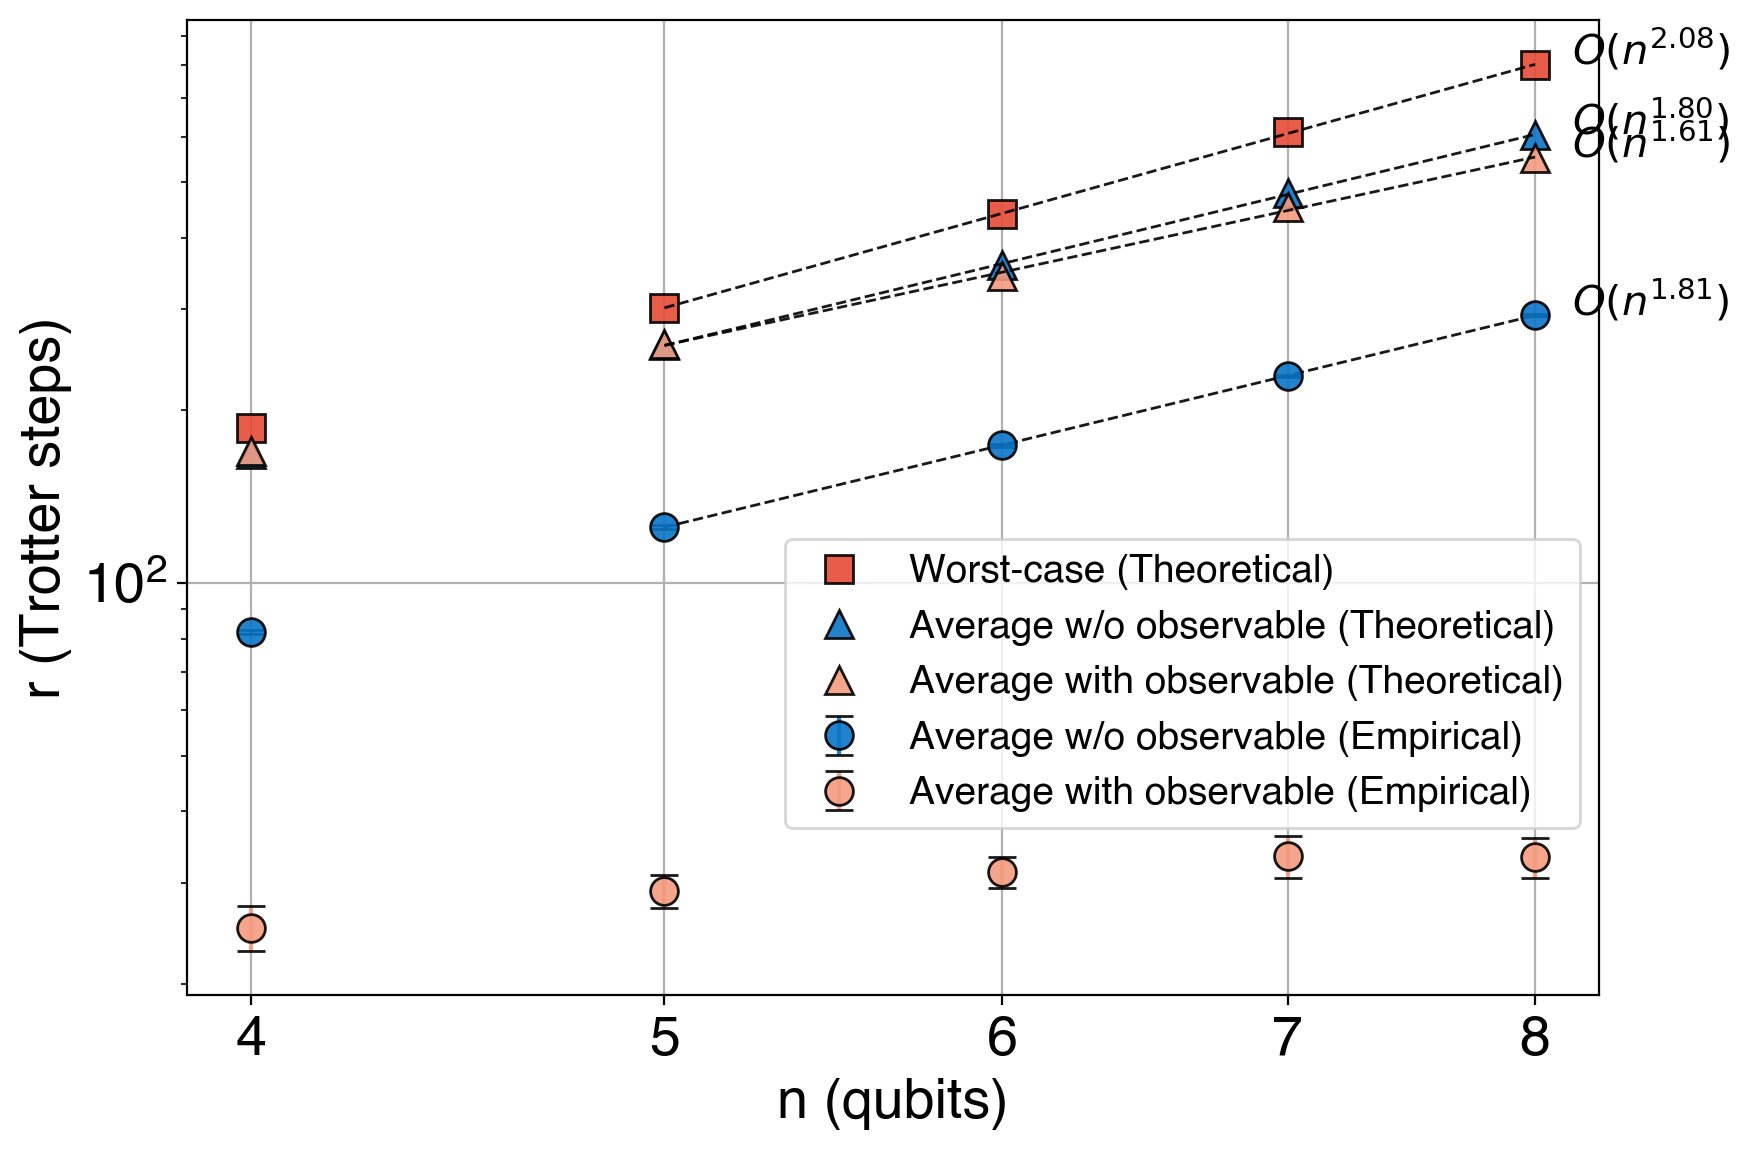

In [9]:
data = pd.read_csv(f'./data/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv')

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(n_list, data['bnd_worst'], 's', label='Worst-case (Theoretical)')
# ax.plot(n_list, data['bnd_averg_corr'], '^', label='Our observable average bound (Correlation)')
ax.plot(n_list, data['bnd_averg'], '^', label='Average w/o observable (Theoretical)', color="#0A75C7")
ax.plot(n_list, data['bnd_averg_magn'], '^', label='Average with observable (Theoretical)', color="#F39B7FFF")
# ax.plot(n_list, data['emp_worst'], 'o', label='Empirical worst (spectral norm)')
# ax.plot(n_list, data['emp_averg'], 'o', label='Empirical Haar average (l2 norm)')
ax.errorbar(n_list, data['emp_averg'], data['emp_averg_std'], fmt='o', label='Average w/o observable (Empirical)', capsize=5, color="#0A75C7")
# ax.plot(n_list, data['emp_averg_magn'], '*', label='Empirical observable (Magnetization)', markersize=12)
ax.errorbar(n_list, data['emp_averg_magn'], data['emp_averg_magn_std'], fmt='o', label='Average with observable (Empirical)', capsize=5, color="#F39B7FFF")
# ax.errorbar(n_list, data['emp_averg_corr'], data['emp_averg_corr_std'], fmt='*', label='Empirical average (Correlation)', capsize=5)
# ax.plot(n_list, data['emp_averg_corr'], '*', label='Empirical average (Correlation)', markersize=12)

# plot_fit(ax, n_list[1:], data['emp_worst'][1:], var=suffix, offset=1.05)
plot_fit(ax, n_list[1:], data['bnd_worst'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['emp_averg'][1:], var=suffix, offset=1.02)
plot_fit(ax, n_list[1:], data['bnd_averg_magn'][1:], var=suffix, offset=1.02)
# ax.set_title(rf'{prefix} (J={J}, h={h}), $\epsilon = {eps}$, $t = n$')
ax.set_xlabel(rf'n (qubits)')
ax.set_ylabel(rf'r (Trotter steps)')
ax.loglog(); ax.grid()
ax.set_xticks(n_list)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.legend()
plt.rc('legend', fontsize=MEDIUM_SIZE-1) 
ax.legend(loc='center right', bbox_to_anchor=(1.0, 0.32))
fig.savefig(f'{figs_dir}/{prefix}_max={n_list[-1]}_{suffix}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

### Worst input (largest singular value)

In [14]:
appro_U = scipy.linalg.expm(-1j * 1 * sum([h.to_matrix() for h in tfi.ham_parity]))
M = exact_U - appro_U
# np.linalg.eigh(M)
print('spectral norm by definition: ', sqrt(np.linalg.eigh(M.conj().T @ M)[0][-1]))
print('largest eigenval: ', np.linalg.eigh(M)[0][-1])
# np.linalg.norm(np.linalg.eigh(exact_U - appro_U)[1][-1], ord=2)
# np.linalg.norm(exact_U - appro_U, ord=-2)
U, S, V = np.linalg.svd(M)
print('largest singular value: ', S[0])
# print(V[0])
norm(V[0])
print(norm(M @ V[0].conj().T))
print(norm(M @ V[0]))
# print(norm(M @ np.linalg.eigh(M)[1][-1]).conj().T)
print('spectral norm by numpy: ', np.linalg.norm(M, ord=2))
# sorted(S)

spectral norm by definition:  (1.9998095531513846+0j)
largest eigenval:  2.8340126451426553
largest singular value:  1.9998095531513838
1.9998095531513842
1.9998095531513846
spectral norm by numpy:  1.9998095531513846


### Error VS time

(-0.007389517548360071-8.673617379884035e-18j)
(-0.006819394843982057-5.204170427930421e-18j)
(-0.0054964813642306085-5.204170427930421e-18j)
(-0.003512707872542112-1.214306433183765e-17j)
(-0.0010157170847666722-4.336808689942018e-18j)
(0.0017979653499583317+1.431146867680866e-17j)
(0.004697630219914137+1.3010426069826053e-17j)
(0.007440012268610387+2.168404344971009e-17j)
(0.009795037802223149-1.9949319973733282e-17j)
(0.011571833631471698+8.565197162635485e-18j)
(0.012641117997625455+1.4094628242311558e-17j)
(0.012950912931106381-1.2685165418080402e-17j)
(0.01253372487066276+3.469446951953614e-18j)
(0.011504474447333775-2.0599841277224584e-18j)
(0.01004926723115572+2.3852447794681098e-18j)
(0.008405632552517937-2.3852447794681098e-18j)
(0.006835377877981677-8.51098705401121e-18j)
(0.005591989778501512-4.445228907190568e-18j)
(0.0048856566052379174+1.235990476633475e-17j)
(0.00485030373402142+1.3010426069826053e-17j)
(0.005518073621803649-2.2985086056692694e-17j)
(0.00680689279654410

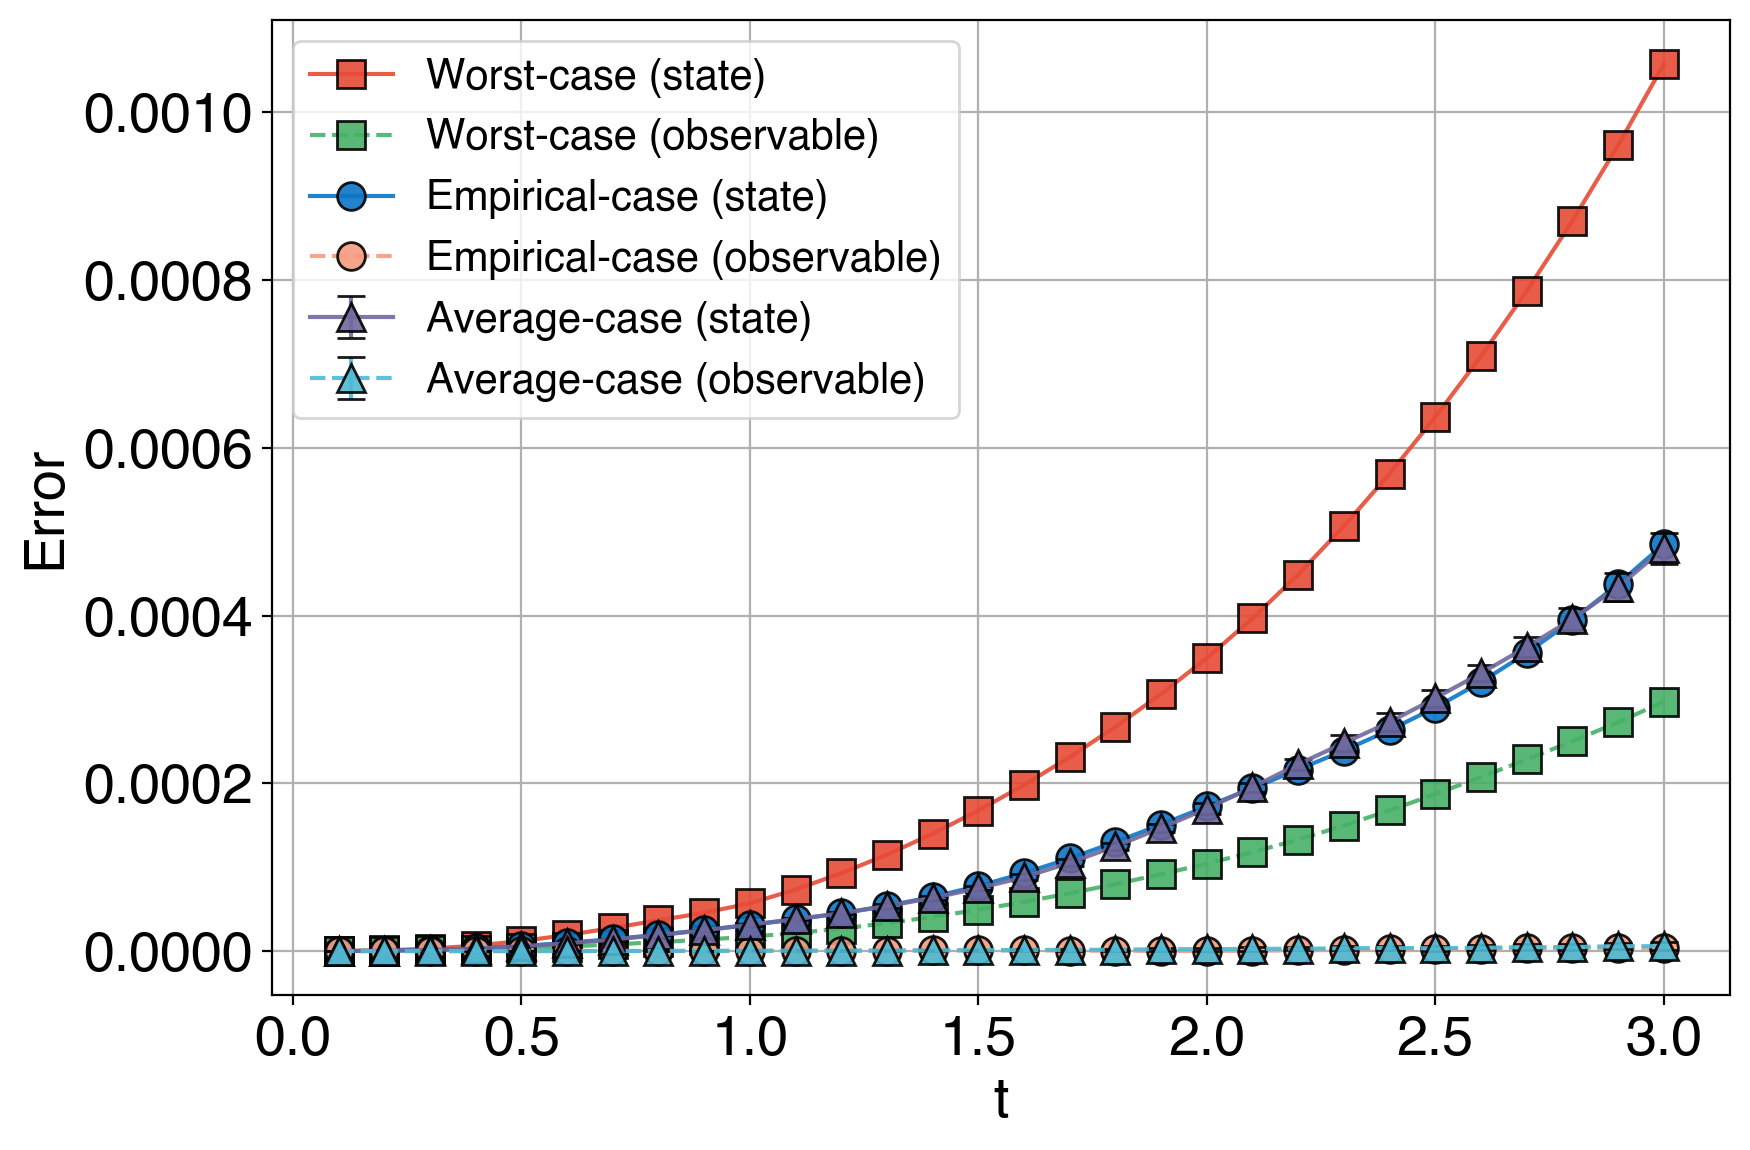

In [146]:
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, SparsePauliOp

prefix, suffix = 'Ising', 't'

r = 100
n_sample = 50
t_list = np.linspace(0.1, 3, 30)

keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
data = dict([(k, []) for k in keys])
data['t'] = t_list

n = 8
J, h = 1, 0.5   
tfi = TF_Ising_1d(n=n, J=-J, h=-h)
# init_st = Statevector.from_label('r'*n).data
# print(init_st)
# init_st = get_ground_state(tfi.ham.to_matrix())[1]
init_st = random_statevector(2**n).data
# init_st = np.linalg.eigh(exact_U - pf_AB(par_group, 3, r, ord=2))[1][-1]

for t in t_list:
    # print(f'------ t = {t} ------')
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
    # magn_op = SparsePauliOp('XYIIIIII').to_matrix()
    # magn_op = SparsePauliOp('XYZYIXYX').to_matrix()
    corr_op = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
    ob = magn_op
    par_group = [h.to_matrix(True) for h in tfi.ham_parity]
    xyz_group = [h.to_matrix(True) for h in tfi.ham_xyz]
    appro_U = pf_r(par_group, t, r, order=2, use_jax=False)
    # init_st = np.linalg.eigh(exact_U - appro_U)[1][-1]

    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_parity]))
    assert np.allclose(exact_U, scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in tfi.ham_xyz])))
    rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    M = exact_U - appro_U
    U, S, V = np.linalg.svd(M)
    # init_st = V[0].conj().T
    # init_st = np.linalg.eigh(exact_U - appro_U)[1][-1]
    # init_st = np.linalg.eigh(M.conj().T @ M)[1][-1]
    # op_norm = sqrt(np.linalg.eigh(M.conj().T @ M)[0][-1])
    # print('operator norm: ', op_norm, np.linalg.norm(M, ord=2))
    # op_norm = np.linalg.norm(tfi.ham.to_matrix(), ord=2)
    # ob = tfi.ham.to_matrix()/np.linalg.norm(tfi.ham.to_matrix(), ord=2)

    data['worst_err'].append(np.linalg.norm(exact_U - appro_U, ord=2))
    averg_st_err = [np.linalg.norm(exact_U @ state.data - appro_U @ state.data) for state in rand_states]
    # print(averg_ob_err)
    data['averg_err'].append(np.mean(averg_st_err))
    data['averg_err_std'].append(np.std(averg_st_err))
    data['typic_err'].append(np.linalg.norm(exact_U @ init_st - appro_U @ init_st, ord=2))
    # exact_st = exact_U @ init_st
    # appro_st = appro_U @ init_st
    # data['typic_err'].append(0.5* np.linalg.norm(np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st), ord='nuc'))
    # print(ground_state.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ ground_state)
    print(init_st.conj().T @ exact_U.conj().T @ ob @ exact_U @ init_st)
    # print(exact_U @ init_st)
    data['worst_ob_err'].append( np.linalg.norm(exact_U.conj().T @ ob @ exact_U - appro_U.conj().T @ ob @ appro_U, ord=2)    )
    averg_ob_err = [np.abs(state.data @ exact_U.conj().T @ ob @ exact_U @ state.data.conj().T - state.data @ appro_U.conj().T @ ob @ appro_U @ state.data.conj().T) for state in rand_states]
    data['averg_ob_err'].append(np.mean(averg_ob_err))
    data['averg_ob_err_std'].append(np.std(averg_ob_err))
    data['typic_ob_err'].append( np.abs(init_st.conj().T @ exact_U.conj().T @ ob @ exact_U @ init_st - init_st.conj().T @ appro_U.conj().T @ ob @ appro_U @ init_st))
    # print("energy: ", init_st.conj().T @ exact_U.conj().T @ ob @ exact_U @ init_st, init_st.conj().T @ appro_U.conj().T @ ob @ appro_U @ init_st)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
ax.plot(data['t'], data['worst_err'], 's-', label='Worst-case (state)')
ax.plot(data['t'], data['worst_ob_err'], 's--', label='Worst-case (observable)')
ax.plot(data['t'], data['typic_err'], 'o-', label='Empirical-case (state)')
ax.plot(data['t'], data['typic_ob_err'], 'o--', label='Empirical-case (observable)')

# ax.plot(data['t'], data['averg_err'], '^-', label='Average-case (state)')
# ax.plot(data['t'], data['averg_ob_err'], '^--', label='Average-case (observable)')
ax.errorbar(data['t'], data['averg_err'], data['averg_err_std'], fmt='^-', label='Average-case (state)', capsize=5)
ax.errorbar(data['t'], data['averg_ob_err'], data['averg_ob_err_std'], fmt='^--', label='Average-case (observable)', capsize=5)

# ax.set_title(rf'H2 chain, init d={d}, H=H2(2d), ob=H2(d), r={r}')
ax.set_xlabel(rf't')
ax.set_ylabel(rf'Error')
ax.grid()
# ax.loglog()
ax.legend()
fig.savefig(f'{figs_dir}/{prefix}_n={n}_r={r}_sample={n_sample}.pdf', dpi=150, bbox_inches='tight')

In [15]:
np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st)
np.linalg.norm(np.outer(exact_st.conj().T, exact_st) - np.outer(appro_st.conj().T, appro_st), ord='nuc')

NameError: name 'exact_st' is not defined

In [83]:
import numpy as np
from scipy.sparse.linalg import expm
# X = np.array([[6, 2], [2, 6]])
# X = np.array([[10, 12], [12, 10]])
X = np.array([[50, 62], [62, 50]])
# X = np.array([[6.1, 52.0], [16, 1.6]])
Id = expm(1j*X) @ expm(-1j*X)
# Id = np.dot(expm(X),expm(-X))
print(Id)
print('scipy: \n', expm(1j*X))
print('jax: \n', jax.scipy.linalg.expm(1j*X))
print('differ: \n', expm(1j*X) - jax.scipy.linalg.expm(1j*X))

[[1.000000e+00-5.382740e-17j 5.613949e-15+5.431801e-17j]
 [5.741244e-15-8.183057e-17j 1.000000e+00+5.769487e-17j]]
scipy: 
 [[ 0.649912-0.176711j -0.193942-0.713284j]
 [-0.193942-0.713284j  0.649912-0.176711j]]
jax: 
 [[ 0.646726-0.178327j -0.197126-0.714903j]
 [-0.197126-0.714903j  0.646726-0.178327j]]
differ: 
 [[0.003186+0.001616j 0.003184+0.001619j]
 [0.003184+0.001619j 0.003186+0.001616j]]


In [73]:
import numpy as np
from scipy.sparse.linalg import expm
# X = np.array([[6.1, 52], [16, 1.6]])
X = np.array([[60, 52], [52, 60]])
Id = np.dot(jax.scipy.linalg.expm(1j*X),jax.scipy.linalg.expm(-1j*X))
print(Id)

[[9.999996e-01+9.329750e-08j 3.597887e-07+3.941467e-07j]
 [3.299864e-07-3.847489e-07j 9.999995e-01-8.006879e-08j]]


In [46]:
# generate 4by4 random hermitian matrix
np.random.seed(0)
A = np.random.randn(4, 4) + 1j * np.random.randn(4, 4)
H = np.dot(A, A.conj().T)
print(jax.scipy.linalg.expm(-1j * t * H))
print(scipy.linalg.expm(-1j * t * H))
print(scipy.linalg.expm(-1j * t * H) - jax.scipy.linalg.expm(-1j * t * H))

[[-0.095848+0.311804j  0.225012-0.61771j   0.412086+0.47338j
   0.250644+0.068484j]
 [ 0.529645+0.717153j  0.124158+0.363135j  0.013719+0.051973j
  -0.086415+0.218051j]
 [ 0.24166 -0.031142j -0.256781-0.474368j -0.348675+0.212443j
  -0.677598+0.154421j]
 [ 0.036466+0.195143j -0.209819-0.292497j -0.630072-0.198825j
   0.595638+0.199333j]]
[[-0.09568 +0.31196j   0.224831-0.617531j  0.412287+0.473379j
   0.250739+0.068511j]
 [ 0.529801+0.716955j  0.124342+0.363306j  0.013726+0.051752j
  -0.086397+0.217953j]
 [ 0.24168 -0.030935j -0.256995-0.474348j -0.348537+0.212569j
  -0.677532+0.154493j]
 [ 0.036487+0.195231j -0.209922-0.292462j -0.629992-0.198773j
   0.595659+0.199354j]]
[[ 1.681671e-04+1.562834e-04j -1.809597e-04+1.780987e-04j
   2.008080e-04-2.086163e-07j  9.444356e-05+2.623349e-05j]
 [ 1.555681e-04-1.978278e-04j  1.840815e-04+1.704991e-04j
   6.598420e-06-2.211183e-04j  1.865625e-05-9.770691e-05j]
 [ 2.014637e-05+2.060942e-04j -2.132356e-04+1.934171e-05j
   1.383722e-04+1.262426e-0

In [90]:
jax_expm = jax.scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
spa_expm = scipy.sparse.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
sci_expm = scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
print(jax_expm - sci_expm)
# print(jax_expm)
# print(spa_expm-sci_expm)

[[-5.364418e-07-1.132488e-06j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j]
 [ 0.000000e+00+0.000000e+00j -4.768372e-07-5.662441e-07j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j]
 [ 0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
  -4.768372e

In [38]:
h_list = h2_finl.qubit_terms
print(len(h_list))
jax_appro_U = pf_r(h_list, t, r, order=2, use_jax=False)
print(jax_appro_U)
# exact_U = jax.scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
h_list = h2_finl.hamiltonian_list
sci_appro_U = pf_r(h_list, t, r, order=2, use_jax=True)
# print(sci_appro_U)
print(jax_appro_U-sci_appro_U)

15
[[-4.004703e-01+9.163097e-01j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  4.047313e-18+1.434732e-19j]
 [ 0.000000e+00+0.000000e+00j -8.682366e-01-4.961505e-01j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   3.150363e-18+5.443906e-18j  0.000000e+00+0.000000e+00j]
 [ 0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
  -8.6823

## Chemistry

In [116]:
from qiskit.quantum_info import random_statevector, Statevector, random_unitary
init_st = Statevector.from_label('0000').data
## tensor product of four random unitaries
def tensor_random_unitaries(n):
    rand_U_list = [random_unitary(2).data for _ in range(n)]
    global_random_U = rand_U_list[0]
    for i in range(1, n):
        global_random_U = np.kron(global_random_U, rand_U_list[i]) 
    return global_random_U
# tensor_random_unitaries(4) @ init_st

In [159]:
n = 6
k= 3
[(random.choices(['I','X','Y','Z'], k=k), random.sample(list(range(0, n)), k), 1)]
# "".join(random.choices(['I','X','Y','Z'], k=n))

[(['X', 'Y', 'Y'], [0, 3, 5], 1)]

In [126]:
from fermion_ham import *

from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, random_unitary

import jax, scipy

prefix, suffix = 'Chem', 't'
# dir = '../figs'

rand_type = 'haar' # '1'
d = 1.0
n_hydrogen = 2
n = n_hydrogen * 2
h2_init = hydrogen_chain_hamiltonian(n_hydrogen, d, verbose=False)
h2_finl = hydrogen_chain_hamiltonian(n_hydrogen, 2*d, verbose=False)
# print(get_ground_state(get_sparse_operator(h2_init.fermion_hamiltonian)))
# print(get_ground_state(get_sparse_operator(h2_finl.fermion_hamiltonian)))

# print(h2_init.jw)
ground_state_energy, ground_state =  get_ground_state(get_sparse_operator(h2_init.fermion_hamiltonian))
# print('ground energy: ', ground_state_energy, ground_state)
# vec0 = np.array([0 for _ in range(len(ground_state))])
# vec0[-1] = 1
# ground_state = vec0/np.sqrt(2)  + ground_state / np.sqrt(2) 
# ground_state = Statevector.from_label('+'*n).data/np.sqrt(2)  + Statevector.from_label('1100').data / np.sqrt(2) 
# ground_state = Statevector.from_label('+'*n).data
ground_state = Statevector.from_label('0'*n).data
# ground_state = random_statevector(2**(2*n_hydrogen)).data
init_st = ground_state.T
# print('init state: ', init_st)  
r = 100
n_sample = 500
t_list = np.linspace(0.1, 15, 15)
dt = 0.1

chem_keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'typic_err_trace', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
chem_data = dict([(k, []) for k in chem_keys])
chem_data['t'] = t_list

# h_ob =  SparsePauliOp.from_sparse_list([('XX', [i, i+1], 1/(n-1)) for i in range(0, n-1)], num_qubits=n).to_matrix()
# h_ob =  SparsePauliOp.from_sparse_list([('Y', [i], 1/n) for i in range(0, n)], num_qubits=n).to_matrix()
rand_ob_str = "".join(random.choices(['I','X','Y','Z'], k=n))
# rand_ob_str = 'IIXI'
print("rand_ob_str: ", rand_ob_str)
h_ob = SparsePauliOp(rand_ob_str).to_matrix()
rand_pstr_list = ["".join(random.choices(['I','X','Y','Z'], k=n)) for _ in range(4)]
print('rand_pstr_list: ', rand_pstr_list)
# h_ob = (SparsePauliOp(rand_pstr_list[0]) + SparsePauliOp(rand_pstr_list[1])).to_matrix()
h_ob = sum([h for h in h2_init.hamiltonian_list])
# h_ob = sum([SparsePauliOp.from_sparse_list([(random.choices(['I','X','Y','Z'], k=n), random.sample(list(range(0, n)), n), 1)], n) for _ in range(5)]).to_matrix()
h_ob = h_ob / np.linalg.norm(h_ob, ord=2)
for t in t_list:
    # print(f'------t: {t}-----')  
    print(f'+', end='')
    r = int(t/dt)
    # print("H norm: ", np.linalg.norm(sum([h for h in h2_init.hamiltonian_list]), ord=2) )
    exact_U = scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    # h_list = h2_finl.qubit_terms
    h_list = h2_finl.hamiltonian_list
    appro_U = pf_r(h_list, t, r, order=2, use_jax=False)
    # exact_U = jax.scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    # h_list = h2_finl.hamiltonian_list
    # appro_U = pf_r(h_list, t, r, order=2, use_jax=True)
    if rand_type == 'haar':
        rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    elif rand_type == '1':
        rand_states = [Statevector(tensor_random_unitaries(n) @ Statevector.from_label('0'*n).data) for _ in range(n_sample)]
    else:
        raise ValueError('rand_type should be either haar or 1')
    M = exact_U - appro_U
    U, S, V = np.linalg.svd(M)
    # init_st = V[0].T

    chem_data['worst_err'].append(2*np.linalg.norm(exact_U - appro_U, ord=2))
    averg_st_err = [np.linalg.norm(np.outer(exact_U @ state.data.conj().T , (exact_U @ state.data.conj().T).conj().T) - np.outer(appro_U @ state.data.conj().T, (appro_U @ state.data.conj().T).conj().T), ord='nuc') for state in rand_states]
    # averg_st_err = [np.linalg.norm(exact_U @ state.data.conj().T - appro_U @ state.data.conj().T) for state in rand_states]
    # print(averg_ob_err)
    chem_data['averg_err'].append(np.mean(averg_st_err))
    chem_data['averg_err_std'].append(np.std(averg_st_err))
    exact_st = exact_U @ init_st
    appro_st = appro_U @ init_st
    # chem_data['typic_err'].append(np.linalg.norm(np.outer(exact_st, exact_st.conj().T) - np.outer(appro_st, appro_st.conj().T), ord='nuc'))
    chem_data['typic_err_trace'].append(2*np.linalg.norm(np.outer(exact_st, exact_st.conj().T) - np.outer(appro_st, appro_st.conj().T), ord='nuc'))
    chem_data['typic_err'].append(2*np.linalg.norm(exact_U @ init_st - appro_U @ init_st))
    # print(ground_state.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ ground_state)

    chem_data['worst_ob_err'].append(np.linalg.norm(exact_U.conj().T @ h_ob @ exact_U - appro_U.conj().T @ h_ob @ appro_U, ord=2))
    averg_ob_err = [np.abs(state.data.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ state.data - state.data.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ state.data) for state in rand_states]
    chem_data['averg_ob_err'].append(np.mean(averg_ob_err))
    chem_data['averg_ob_err_std'].append(np.std(averg_ob_err))
    chem_data['typic_ob_err'].append( np.abs(init_st.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ init_st - init_st.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ init_st))
    # print("energy: ", init_st.conj().T @ exact_U.conj().T @ h_ob @ exact_U @ init_st, init_st.conj().T @ appro_U.conj().T @ h_ob @ appro_U @ init_st)


# pstr: 15, ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'YXXY', 'YYXX', 'XXYY', 'XYYX', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
# groups: 2
[[{'IIII': (-0.3276081896748102+0j)}, {'ZIII': (0.13716572937099497+0j)}, {'IZII': (0.13716572937099497+0j)}, {'IIZI': (-0.13036292057109025+0j)}, {'IIIZ': (-0.13036292057109025+0j)}, {'ZZII': (0.15660062488237947+0j)}], [{'YXXY': (0.049197645871367546+0j)}, {'YYXX': (-0.049197645871367546+0j)}, {'XXYY': (-0.049197645871367546+0j)}, {'XYYX': (0.049197645871367546+0j)}, {'ZIZI': (0.10622904490856078+0j)}, {'ZIIZ': (0.15542669077992832+0j)}, {'IZZI': (0.15542669077992832+0j)}, {'IZIZ': (0.10622904490856078+0j)}, {'IIZZ': (0.16326768673564335+0j)}]]
# pstr: 15, ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'YXXY', 'YYXX', 'XXYY', 'XYYX', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
# groups: 2
[[{'IIII': (-0.5339363487727404+0j)}, {'ZIII': (0.06727930458983424+0j)}, {'IZII': (0.06727930458983425+0j)}, {'IIZI': (0.006651295687574471+0j)}, {'IIIZ': (

In [110]:
worst_st_err_bnd = tight_bound(h_list, 2, 1, 10, type='spectral')
averg_st_err_bnd = tight_bound(h_list, 2, 1, 10, type='fro')
print(worst_st_err_bnd, averg_st_err_bnd)

3.756541658740307e-05 1.8733861863848893e-05


/var/folders/zc/9k4hbf5n07d86qpnf8lqkw3w0000gn/T/ipykernel_36064/2309736555.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{figs_dir}/{prefix}_d={d}_r={r}_n={n}_sample={n_sample}_violin.pdf', dpi=150, bbox_inches='tight')
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


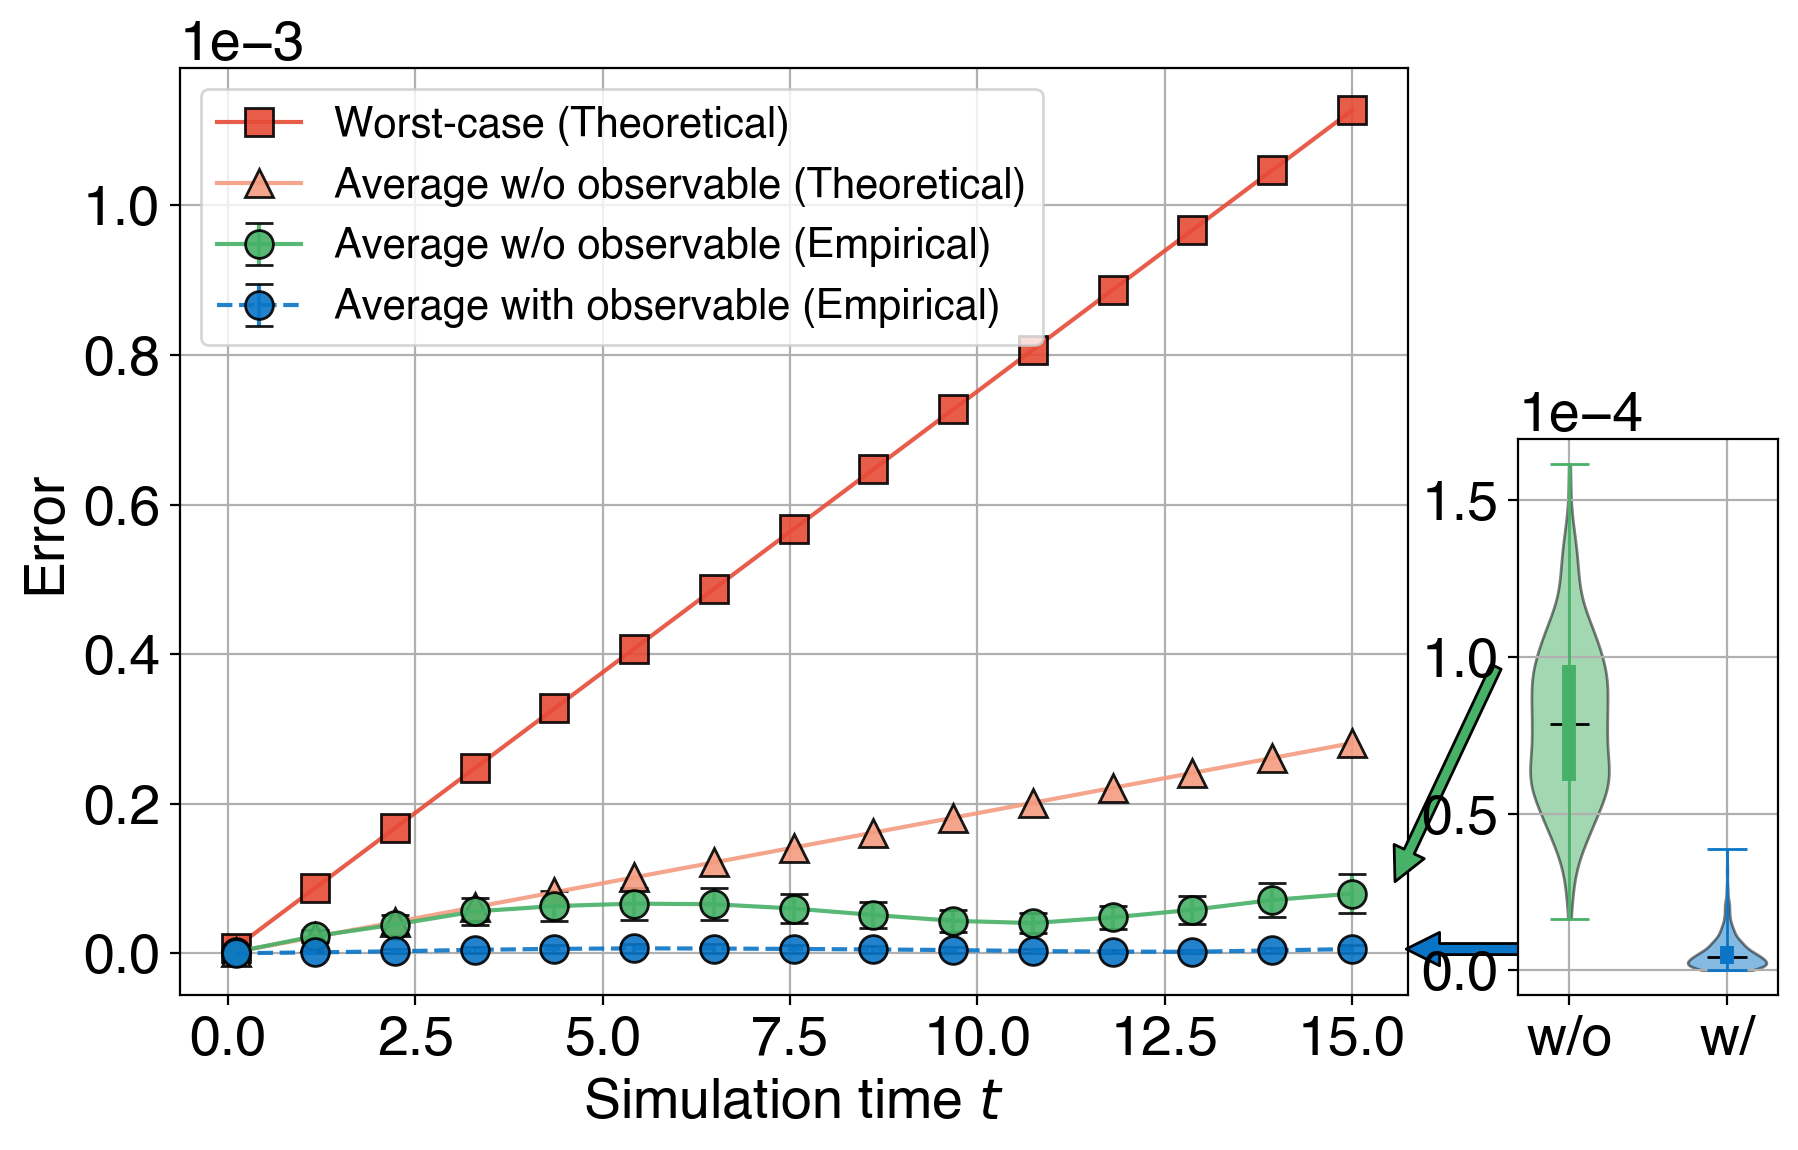

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
s = 1
# ax.plot(chem_data['t'][::s], chem_data['worst_err'][::s], 's-', label='Worst-case (state, empirical)')
ax.plot(chem_data['t'][::s], [worst_st_err_bnd*t*2 for t in chem_data['t'][::s]], 's-', label='Worst-case (Theoretical)')
# ax.plot(chem_data['t'], chem_data['typic_err'], 'o-', label='Specific-case (state, l2 norm)')
# ax.plot(chem_data['t'], chem_data['typic_err_trace'], 'o-', label='Specific-case (state, trace norm)')
# ax.plot(chem_data['t'], chem_data['typic_ob_err'], 'o--', label='Specific-case (observable)')

# ax.plot(chem_data['t'], chem_data['averg_err'], '^-', label='Average-case (state)')
# ax.plot(chem_data['t'], chem_data['averg_ob_err'], '^--', label='Average-case (observable)')
ax.errorbar(chem_data['t'][::s], chem_data['averg_err'][::s], chem_data['averg_err_std'][::s], fmt='o-', label='Average w/o observable (Empirical)', capsize=5)
# ax.plot(chem_data['t'][::s], np.array(chem_data['worst_ob_err'][::s]), 's--', label='Worst-case (observable)')

ax.errorbar(chem_data['t'][::s], chem_data['averg_ob_err'][::s], chem_data['averg_ob_err_std'][::s], fmt='o--', label='Average with observable (Empirical)', capsize=5)
ax.plot(chem_data['t'][::s], [averg_st_err_bnd*t for t in chem_data['t'][::s]], '^-', label='Average w/o observable (Theoretical)')
# ax.set_title(rf'H{n_hydrogen} chain, init d={d}, H=H{n_hydrogen}(2d), ob=H2(d), dt={0.1}')
# ax.set_title(rf'H{n_hydrogen} chain, init d={d}, H=H2(2d), ob=H2(d), r={r}')
ax.set_xlabel(rf'Simulation time $t$')
ax.set_ylabel(rf'Error')
ax.grid()
# ax.loglog()
ax.legend()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width=1.3, height="100%", bbox_to_anchor=(1.09, .0, .5, 0.6), bbox_transform=ax.transAxes, loc=2, borderpad=0)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axins.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
violin_data = [averg_st_err, averg_ob_err]
# violin_data = [[chem_data['worst_err'][-1]], averg_st_err, averg_ob_err]
# axins.boxplot(violin_data)
vplots = axins.violinplot(violin_data, showmeans=False, showmedians=True)
axins.set_xticks([1,2], labels=['w/o', 'w/'])
# axins.set_xticks([1,2,3], labels=['Worst', 'state', 'ob'])
colors = ["#47B167", "#0A75C7"]
# colors = ["#E64B35FF", "#47B167", "#0A75C7"]
# colors = ["#0A75C7", "#F39B7FFF"]
# Set the color of the violin patches
for pc, color in zip(vplots['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('k')
    pc.set_alpha(0.5)
for partname in ('cbars', 'cmins','cmaxes','cmedians'):
    vp = vplots[partname]
    vp.set_edgecolor(colors)
    vp.set_linewidth(1.0)
vplots['cmedians'].set_edgecolor('k')
quartile1, medians, quartile3 = np.percentile(violin_data, [25, 50, 75], axis=1)
# quartile1, medians, quartile3 = np.percentile([averg_st_err, averg_ob_err], [25, 50, 75], axis=1)
axins.vlines([1, 2], quartile1, quartile3, color=colors, linestyle='-', lw=5)
# axins.set_ylim([0-0.05*chem_data['worst_err'][-1], 1.05*chem_data['worst_err'][-1]])
axins.grid()
# axins.vlines([2, 3], quartile1, quartile3, color=colors[1:], linestyle='-', lw=5)
ax.annotate('', (chem_data['t'][-1]+.5, chem_data['averg_err'][-1]), (chem_data['t'][-1]+2, chem_data['averg_err'][-1]*4), arrowprops=dict(facecolor=colors[0], shrink=0.05))
ax.annotate('', (chem_data['t'][-1]+.5, chem_data['averg_ob_err'][-1]), (chem_data['t'][-1]+5, chem_data['averg_ob_err'][-1]), arrowprops=dict(facecolor=colors[1], shrink=0.05))
# for pc, color in zip(vplots['cmedians'], colors):
#     pc.set_colors(color)
# ax.indicate_inset_zoom(axins, edgecolor="black")
# axins.set_xticklabels(['state', 'ob'])
fig.savefig(f'{figs_dir}/{prefix}_d={d}_r={r}_n={n}_sample={n_sample}_violin.pdf', dpi=150, bbox_inches='tight')

In [50]:
chem_data['worst_err']
print(chem_data['typic_err'])
print(chem_data['typic_err_trace'])

[2.2302179854129235e-16, 7.19934981095077e-15, 6.097155734582679e-15, 2.339911936640563e-14, 5.248161751862041e-14, 1.956837438905832e-14, 9.55283347711449e-15, 5.769197914178396e-14, 5.5913378173338915e-14, 3.8539297720884186e-14, 1.1157255815467003e-13, 2.714059180160804e-14, 5.233572086866124e-14, 2.904999755920358e-14, 8.296034770914644e-14, 7.896582515334823e-14, 1.3376340020172536e-13, 1.2639766646870912e-13, 1.5582725515015642e-14, 7.975482479445506e-14, 3.52509499919427e-13, 1.439611259725927e-13, 1.5061516584960855e-13, 2.5717005279260285e-14, 1.1492016911829462e-13, 2.925584923831706e-13, 6.01347774565669e-14, 6.432595727019165e-14, 1.9309668423330524e-13, 5.805411046234418e-14, 8.620549947642086e-14, 3.8577144009026263e-13, 3.8603615253538854e-13, 1.382384372556575e-13, 1.0303665317849752e-13, 6.326199407291347e-13, 1.0324101292297191e-13, 1.7772808602974619e-13, 1.1230475352158088e-13, 9.550403272829116e-14]
[2.2206754384909106e-16, 7.1054504600052e-15, 6.10624636503915e-15

## Ising model with three kinds of observables (Qiskit code)

Text(0.5, 0.98, 'Observable evolution')

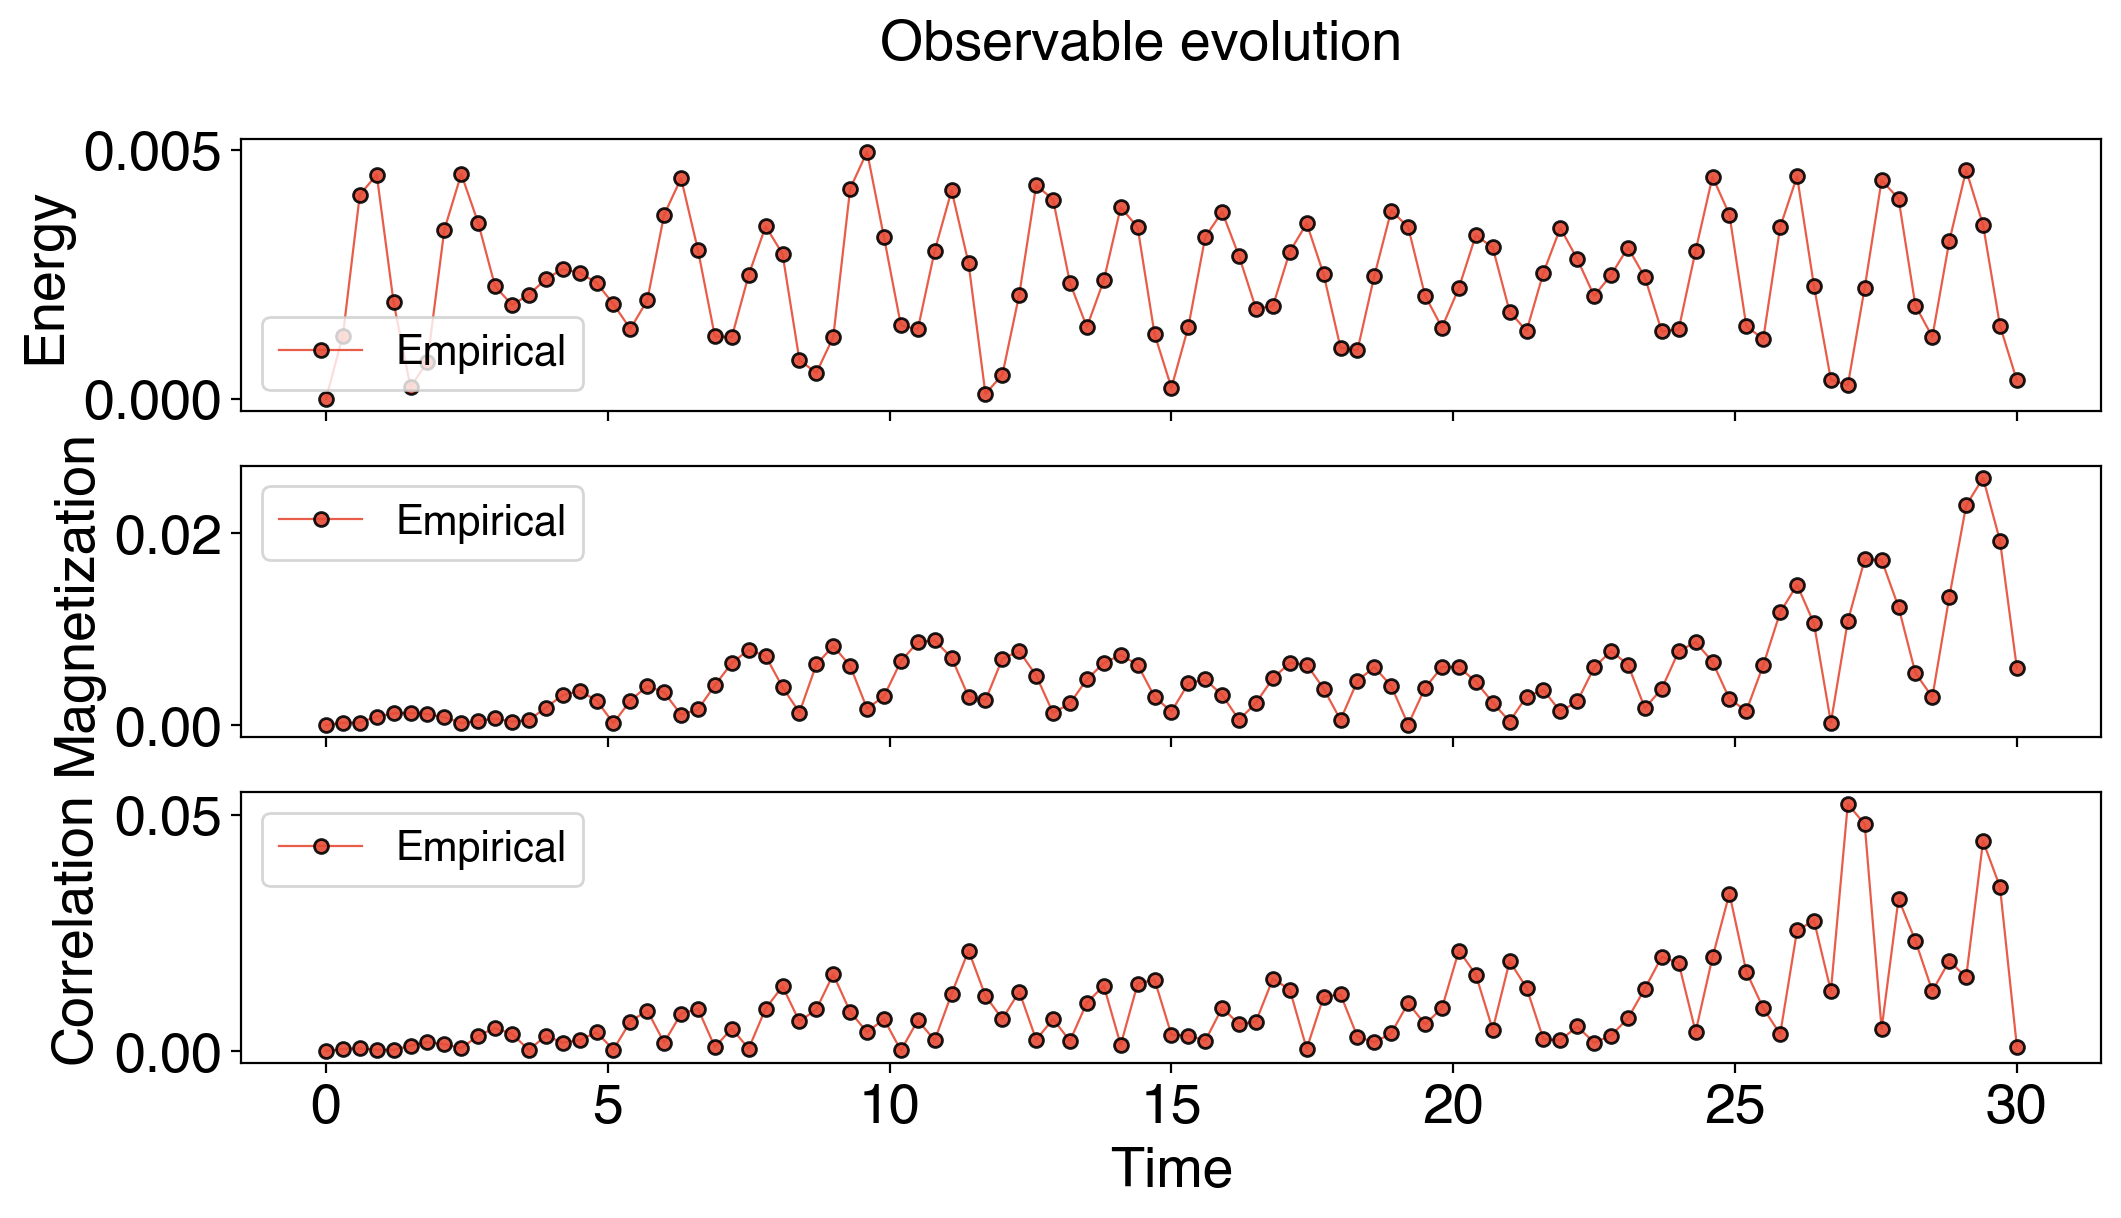

In [325]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

from math import pi

L = 5
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=pi / 8)

H_array = H.to_matrix()
# H

from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.synthesis import ProductFormula, SuzukiTrotter

# final_time = 1.6

# # First spin up, second spin down
# # (remember that the labels are interpreted from right to left)
# initial_state = Statevector.from_label("10")

# problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

num_timesteps = 100
trotter = TrotterQRTE(product_formula=SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
print(trotter)

magnetization_op = SparsePauliOp.from_sparse_list([("Z", [i], 1.0/L) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L) / (L - 1)

final_time = 30.0
initial_state = Statevector.from_label("0"*L)
initial_state = random_statevector(2**L)
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H/np.linalg.norm(H_array, ord=2), magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

import scipy as sc


# # We define a slightly denser time mesh
# exact_times = np.linspace(0, final_time, 101)

# # We compute the exact evolution using the exp
# exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
# exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
# exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
# exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

def exact_evolution_obs(t):
    sv = initial_state.evolve(sc.linalg.expm(-1j * t * H_array))
    exact_energy = np.real(sv.expectation_value(H/np.linalg.norm(H_array, ord=2)))
    exact_magnetization = np.real(sv.expectation_value(magnetization_op))
    exact_correlation = np.real(sv.expectation_value(correlation_op))

    return exact_energy, exact_magnetization, exact_correlation

times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
obs_data = np.array([exact_evolution_obs(t) for t in times])
# print(obs_data)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, figsize=(12, 6), sharex=True)
axes[0].plot(times, abs(observables[:, 0]-obs_data[:, 0]), label="Empirical", marker=".", ls="-", lw=0.8)
axes[1].plot(times, abs(observables[:, 1]-obs_data[:, 1]), label="Empirical", marker=".", ls="-", lw=0.8)
axes[2].plot(times, abs(observables[:, 2]-obs_data[:, 2]), label="Empirical", marker=".", ls="-", lw=0.8)
# axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
# axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
# axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")

axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Correlation")
axes[2].set_xlabel("Time")
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.suptitle("Observable evolution")